# 영화 리뷰를 사용한 텍스트 분류
- 출처: https://www.tensorflow.org/tutorials/keras/text_classification?hl=ko

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

print(tf.__version__)

2.8.0


In [2]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb', url, untar=True, cache_dir='.', cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [3]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [5]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [6]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: '.\\aclImdb\\train\\unsup'

## tf.keras.utils.text_dataset_from_directory()
- 디렉토리 안에 있는 텍스트 파일을 tf.data.Dataset 클래스의 인스턴스?로 생성해줌
- 폴더 이름이 class_names가 될 것
    - labels='inffered'(default): 라벨값을 디렉토리 구조에 맞게 정수로 저장(파일이 들어있는 폴더수로 정수라벨 생성하는 듯)
- subset: 어떤데이터를 받을 것인지("training", "validation" or "both")
    - 사용하려면 validation_split이 적용되어야 함

In [7]:
batch_size = 32
# validation_split 및 subset 인수를 사용할 때 검증 및 훈련 분할이 겹치지 않도록 하기 위함
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=.2,
    subset='training',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [8]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print('Review', text_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into complica

In [9]:
print('Label 0 corresponds to', raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [10]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [11]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## tf.keras.layers.TextVectorization()
- 데이터를 표준화, 토큰화, 벡터화
- 표준화: 구두점이나 HTML요소를 제거해 데이터세트 전처리
    - 다만, TextVectorization()레이어가 HTML코드를 제거해주진 않으므로 직접 함수만들어서 처리해야 함
- 토큰화: 문자열을 여러 토큰으로 분할
- 벡터화: 토큰을 숫자로 변환해 신경망에 공급될 수 있도록 함
- training-serving_skew(훈련-테스트 왜곡)방지를 위해 훈련데이터와 테스트데이터를 동일한 방식으로 전처리 해줘야함!

- string.punctuation: https://blog.naver.com/PostView.nhn?isHttpsRedirect=true&blogId=owl6615&logNo=222290368035

In [12]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [13]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

- adapt(): 전처리 레이어의 상태를 데이터세트에 맞춤

In [14]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [15]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [17]:
# 데이터세트로부터 배치 하나 가져와서 적용
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print('Review: ', first_review)
print('Label: ', raw_train_ds.class_names[first_label])

Review:  tf.Tensor(b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)', shape=(), dtype=string)
Label:  neg


In [18]:
# 각 정수에 해당하는 토큰(문자열) 조회하기
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [19]:
# 테스트가 끝났으니 데이터 모두에 적용해주기!
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## 성능을 높이도록 데이터세트 구성하기
- .cache(): 데이터가 디스크에서 로드된 후 메모리에 데이터를 보관
    - 모델 훈련하는 동안 데이터세트로 인해 발생하는 병목현상 방지
- .prefetch(): 모델을 훈련하는 동안 다음 데이터를 미리 읽어들임으로써 훈련시간 줄임
    - 미리 가져올 요소의 수는 단일 학습 단계에서 사용되는 배치수와 같거나 많아야 함.
    - tf.data.AUTOTUNE: tf.data 런타임이 런타임에 값을 동적으로 조정
        - 사용하지 않고 수동조정도 가능

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 모델 생성
- Embedding(input_dim, output_dim): 정수 인코딩한 결과를 고정된 크기의 밀집 벡터로 바꿔줌
    - 모델의 첫번째 레이어로만 사용 가능
    - input_dim = 어휘목록크기, 정수인코딩 최대값 + 1
    - 최종 차원: (batch, sequence, embedding)
- GlobalAveragePooling1D(): sequence 차원에 대해 평균을 계산해 각 샘플에 대해 고정된 길이의 출력 벡터 반환
    - 길이가 다른 입력을 다루는 가장 간단한 방법
- sigmoid 활성화 함수를 사용해 하나의 확률(or 신뢰도)값을 반환하는 완전 연결층

In [22]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features+1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

## 손실함수와 옵티마이저
- BinaryCrossentropy, BinaryAccuracy는 이진분류용
- 다중 분류시에는 SparseCategoricalCrossentropy, accuracy로 적용하기

In [24]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## 모델 훈련

In [25]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 10s 13ms/step - loss: 0.6641 - binary_accuracy: 0.6902 - val_loss: 0.6149 - val_binary_accuracy: 0.7722
Epoch 2/10
625/625 [==============================] - 5s 7ms/step - loss: 0.5486 - binary_accuracy: 0.8006 - val_loss: 0.4984 - val_binary_accuracy: 0.8192
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4448 - binary_accuracy: 0.8445 - val_loss: 0.4202 - val_binary_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3780 - binary_accuracy: 0.8652 - val_loss: 0.3738 - val_binary_accuracy: 0.8598
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3355 - binary_accuracy: 0.8791 - val_loss: 0.3454 - val_binary_accuracy: 0.8678
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3049 - binary_accuracy: 0.8885 - val_loss: 0.3261 - val_binary_accuracy: 0.8714
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

## 모델 평가하기

In [26]:
loss, accuracy = model.evaluate(test_ds)

print('Loss: ', loss)
print('Accuracy: ', accuracy)

782/782 [==============================] - 7s 8ms/step - loss: 0.3098 - binary_accuracy: 0.8738
Loss:  0.3097520172595978
Accuracy:  0.8737599849700928


## 정확도와 손실 그래프 그리기

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

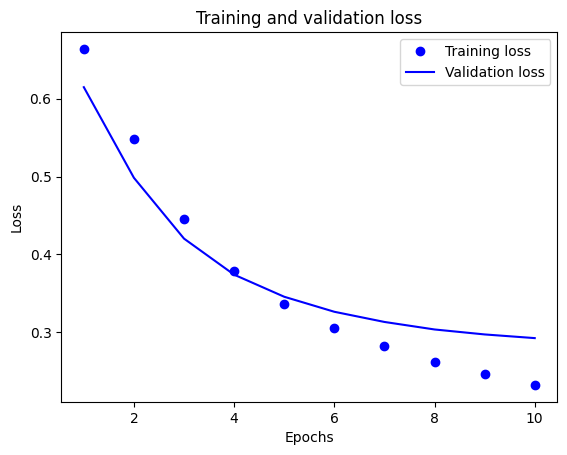

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 'bo': 'blue dot'
plt.plot(epochs, loss, 'bo', label='Training loss')
# 'b': solid blue line
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

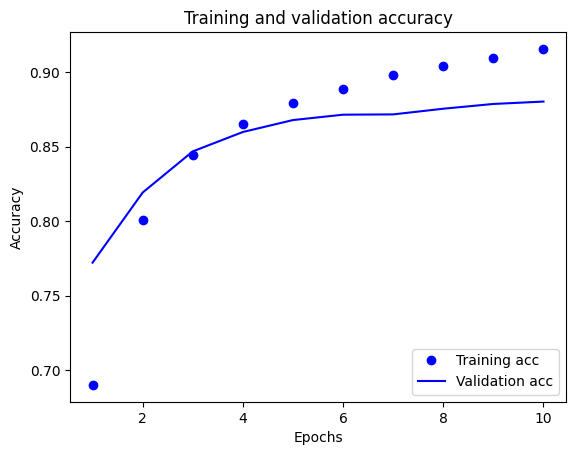

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## 모델 내보내기
- 정수인코딩 해주는 TextVectorization 레이어도 추가해서 내보낼 수 있음
    - 배포 단순화
- Activation 레이어는 위에선 없었는데.. 새로 추가한듯?

In [31]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

# 훈련된 가중치를 적용 및 metrics 변경해 새로운 모델 생성
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

# 정수 인코딩이 안된 Dataset인 raw_test_ds로 테스트해보기
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

C:\python\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


782/782 [==============================] - 9s 11ms/step - loss: 0.3098 - accuracy: 0.8738
0.8737599849700928


## 새로운 데이터로 추론하기
- model.predict()

In [32]:
examples = ['The movie was great!', 'The movie was okay.', 'The movie was terrible...']

export_model.predict(examples)

array([[0.6385975 ],
       [0.46317557],
       [0.37990034]], dtype=float32)